1/1 [==============================] - 8s 8s/step
Class ID: 404
Class name: airliner
1/1 [==============================] - 0s 60ms/step
Class ID: 404
Class name: airliner
1/1 [==============================] - 0s 28ms/step
Class ID: 455
Class name: bottlecap
1/1 [==============================] - 0s 28ms/step
Class ID: 954
Class name: banana
1/1 [==============================] - 0s 28ms/step
Class ID: 957
Class name: pomegranate
1/1 [==============================] - 0s 31ms/step
Class ID: 292
Class name: tiger


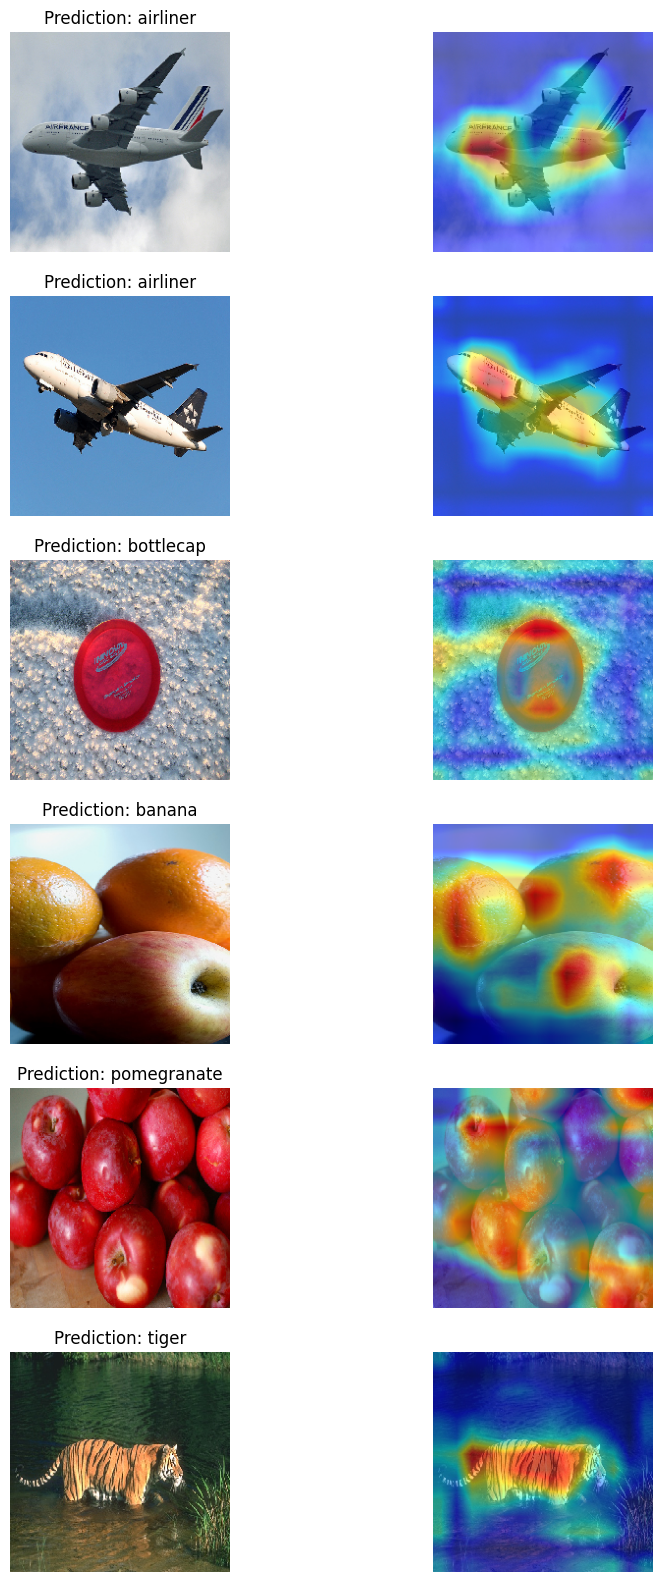

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2

# Load the VGG16 model
model = VGG16(weights="imagenet")

def load_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x, img

def grad_cam(input_model, image_array, cls_index, layer_name):
    """GradCAM method for visualizing input saliency."""
    grad_model = tf.keras.models.Model([input_model.inputs], [input_model.get_layer(layer_name).output, input_model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(image_array)
        loss = predictions[:, cls_index]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = np.ones(output.shape[0: 2], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (224, 224))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    # Return to BGR [0..255] from the preprocessed image
    image_rgb = image_array[0, :]
    image_rgb -= image_rgb.min()
    image_rgb = np.minimum(image_rgb, 255)

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
    cam = np.float32(cam) + np.float32(image_rgb)
    cam = 255 * cam / np.max(cam)
    return np.uint8(cam), heatmap

# Directory containing images
dir_path = './images/'

fig, axs = plt.subplots(len(os.listdir(dir_path)), 2, figsize=(10, 20))

for i, img_name in enumerate(os.listdir(dir_path)):
    img_path = os.path.join(dir_path, img_name)
    img_array, img_original = load_image(img_path)

    preds = model.predict(img_array)
    class_idx = np.argmax(preds[0])
    class_name = decode_predictions(preds, top=1)[0][0][1]
    print("Class ID:", class_idx)
    print('Class name:', class_name)

    cam, heatmap = grad_cam(model, img_array, class_idx, "block5_conv3")

    axs[i][0].imshow(img_original)
    axs[i][0].axis('off')
    axs[i][1].imshow(cv2.cvtColor(cam, cv2.COLOR_BGR2RGB))
    axs[i][1].axis('off')
    axs[i][0].set_title(f"Prediction: {class_name}")

plt.show()
